<a href="https://colab.research.google.com/github/Amirbn73/Image-Segmentation/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=2c8bd860d12051ab4a99e5538e7f44f89885cb528702338f01033cc604e0fee0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=f2932213408178cf2550c082931a194afed27ff8cec6fd1f2eba1245f4ce8f7e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (3/3), done.


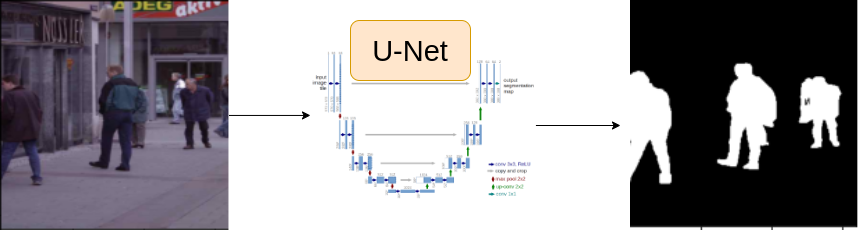

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm #tqdm module provides progress bars for loops and iterables. This is helpful for visualizing the progress of lengthy computations.

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 25
BATCH_SIZE = 16
LR = 0.003
IMAGE_SIZE = 320

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#OpenCV reads images in BGR (Blue-Green-Red) color format by default.
# This line converts the image from BGR to RGB (Red-Green-Blue) format,
#  which is more commonly used in other libraries and for visualization.

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

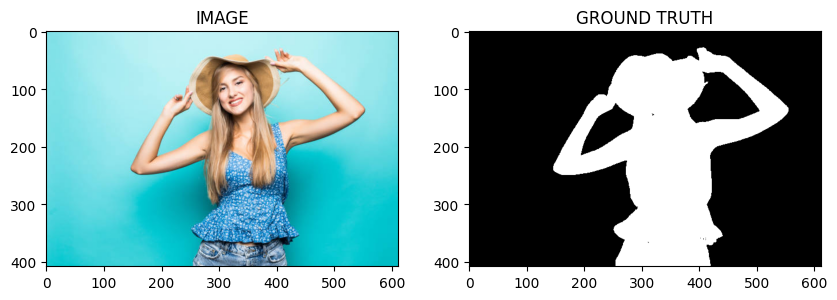

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

In [ ]:
type(image)

numpy.ndarray

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset #This is a base class that you'll typically inherit from when creating your own custom dataset classes in PyTorch.

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx): #takes an index idx and returns the corresponding data sample
    row = self.df.iloc[idx]     #  (image and mask) from your dataset. This is how PyTorch's data loaders will access your data.


    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    #transpose the image and mask arrays, rearranging their dimensions
    # from (height, width, channels) to (channels, height, width).
    #  This is the "channel-first" format that PyTorch typically expects.
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


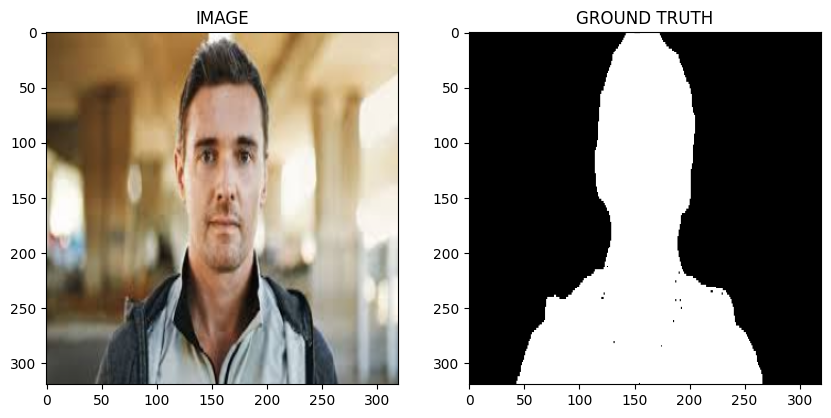

In [ ]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss #Dice Coefficient = 2 * |X ∩ Y| / (|X| + |Y|), Dice Loss = 1 - Dice Coefficient

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      #more stable than applying the sigmoid activation and binary cross-entropy loss separately.
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 65.7MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_df(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad() #eset gradients before calculating them for the current batch.
    logits, loss = model(images, masks)
    loss.backward() #performs backpropagation. It calculates the gradients of the loss with respect to all the model's parameters.
    optimizer.step() #This uses the calculated gradients to update the model's parameters, taking a step in the direction that minimizes the loss.

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_df(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad(): #This context manager temporarily disables gradient calculation. During evaluation, you're only interested in the model's predictions and the loss value, not in updating the model's weights, so there's no need to compute gradients, saving memory and computation time.
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_df(trainloader, model, optimizer)
  valid_loss = eval_df(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved Best Model!')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss:.4f} Valid Loss : {valid_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Saved Best Model!
Epoch : 1 Train_loss : 0.7127 Valid Loss : 1.0373


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Saved Best Model!
Epoch : 2 Train_loss : 0.3487 Valid Loss : 0.4121


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Saved Best Model!
Epoch : 3 Train_loss : 0.3084 Valid Loss : 0.2784


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch : 4 Train_loss : 0.2632 Valid Loss : 0.3377


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 5 Train_loss : 0.3060 Valid Loss : 0.3129


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Saved Best Model!
Epoch : 6 Train_loss : 0.2389 Valid Loss : 0.2621


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Saved Best Model!
Epoch : 7 Train_loss : 0.1930 Valid Loss : 0.2273


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Saved Best Model!
Epoch : 8 Train_loss : 0.1982 Valid Loss : 0.1949


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Epoch : 9 Train_loss : 0.1801 Valid Loss : 0.2049


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch : 10 Train_loss : 0.1636 Valid Loss : 0.2142


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Saved Best Model!
Epoch : 11 Train_loss : 0.1452 Valid Loss : 0.1744


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 12 Train_loss : 0.1758 Valid Loss : 0.2987


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 13 Train_loss : 0.1814 Valid Loss : 0.1889


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Saved Best Model!
Epoch : 14 Train_loss : 0.1363 Valid Loss : 0.1645


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 15 Train_loss : 0.1554 Valid Loss : 0.2046


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch : 16 Train_loss : 0.1405 Valid Loss : 0.2386


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 17 Train_loss : 0.1149 Valid Loss : 0.1828


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch : 18 Train_loss : 0.1324 Valid Loss : 0.1700


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Saved Best Model!
Epoch : 19 Train_loss : 0.1048 Valid Loss : 0.1505


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 20 Train_loss : 0.1390 Valid Loss : 0.2001


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 21 Train_loss : 0.1573 Valid Loss : 0.2074


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch : 22 Train_loss : 0.1277 Valid Loss : 0.1779


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 23 Train_loss : 0.1065 Valid Loss : 0.2145


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 24 Train_loss : 0.1229 Valid Loss : 0.1778


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

Epoch : 25 Train_loss : 0.1315 Valid Loss : 0.1930


# Task 9 : Inference

In [ ]:
idx = 57

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-29-fd5f0cd1894b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


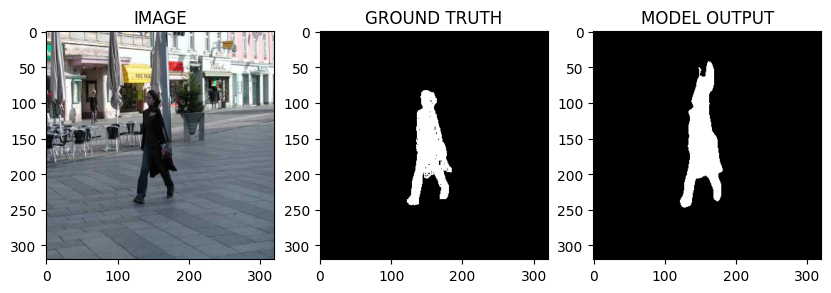

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))